# External evidence

In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from datetime import datetime

In [52]:
SMALL_SIZE = 24
MEDIUM_SIZE = 30

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
#plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=MEDIUM_SIZE)  # fontsize of the figure title

In [2]:
with open("../../data/raw/eprints/eprints_repos.txt", "r") as f:
    eprints_repos = f.read().split("\n")

In [3]:
data_dir = "../../data/raw/eprints"

Merging info from all repos

In [4]:
dfs = []
for eprints_repo in eprints_repos:
    try:
        urls = pd.read_csv(os.path.join(data_dir, "cleaned_repo_urls", f"cleaned_urls_{eprints_repo}_2010-_github.com.csv"))
        metadata = pd.read_csv(os.path.join(data_dir, "publication_urls", f"extracted_pdf_urls_{eprints_repo}_2010-.csv"))
    except FileNotFoundError:
        continue
    metadata["date"] = pd.to_datetime(metadata.date, errors="coerce")
    metadata["year"] = metadata.date.dt.year
    df = pd.merge(urls, metadata, how="right", on=["title", "author_for_reference", "pdf_url"])
    df["eprints_repo"] = eprints_repo
    dfs.append(df)
df = pd.concat(dfs)  # might contain duplicates

Data cleaning

In [5]:
def clean_dataset(df, remove_duplicate_pdf_mentions, remove_duplicate_pub_mentions):
    """Perform data cleaning steps.

    Args:
        df (pd.DataFrame): dataset
        remove_duplicate_pdf_mentions (bool): if True, drop duplicate links in one PDF
        remove_duplicate_pub_mentions (bool): if True, drop duplicate links ocurring on the same page in different PDF links (across repos), and also all duplicates of publications with no links

    Returns:
        pd.DataFrame: cleaned dataset
    """
    df = df[df.year <= 2023]
    df = df.astype({"year": int})
    # drop duplicate links in one PDF
    if remove_duplicate_pdf_mentions:
        df = df.drop_duplicates(subset=["title", "author_for_reference", "pdf_url", "github_user_cleaned_url"])
    # drop duplicate links ocurring on the same page in different PDF links (across repos), and also all duplicates of publications with no github links
    if remove_duplicate_pub_mentions:
        df = df.drop_duplicates(subset=["title", "author_for_reference", "page_no", "github_user_cleaned_url"])
    return df


In [6]:
df = clean_dataset(df, True, True)

Total number of GitHub URLs in ePrints per year:

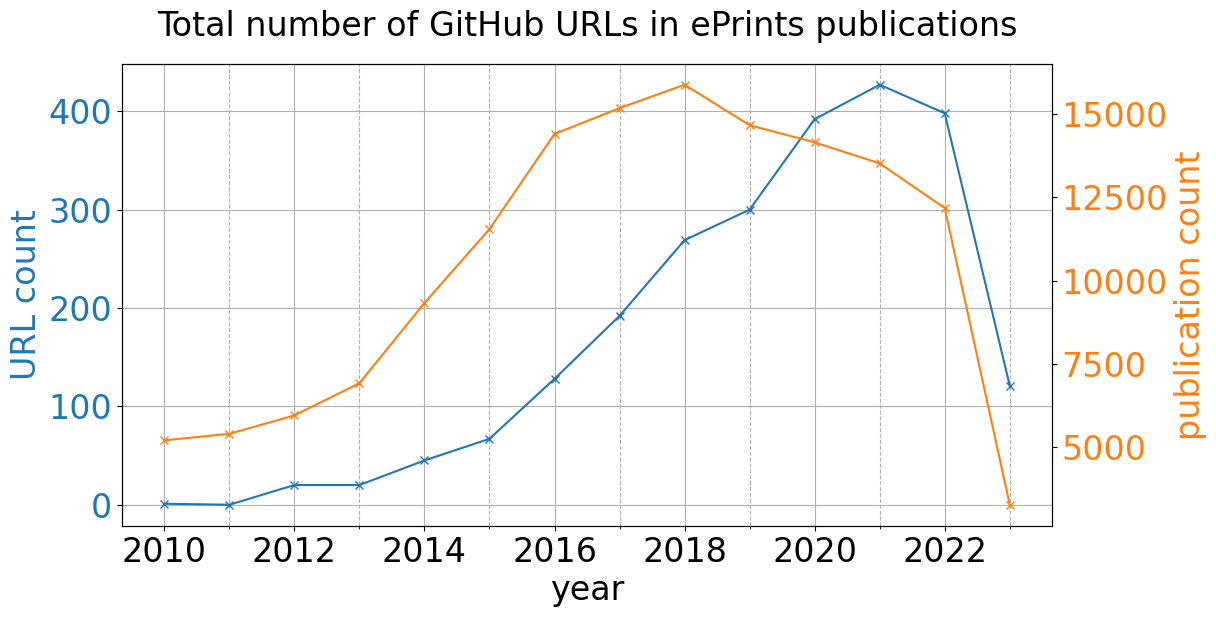

In [115]:
fig1, ax1 = plt.subplots(figsize=(12,6))
colors = ['tab:blue', 'tab:orange']
urls_per_year = df.groupby("year")['github_user_cleaned_url'].count()
urls_per_year.plot(
    ax=ax1,
    xlabel="year",
    marker="x",
    color=colors[0],
)
ax1.set_title("Total number of GitHub URLs in ePrints publications",pad=20)
ax1.tick_params(axis='y', labelcolor=colors[0])
ax1.set_ylabel("URL count", color=colors[0])

ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.grid(which="major")
ax1.grid(which="minor", linestyle="--")

ax2 = ax1.twinx()
pubs_per_year = df.groupby("year")['pdf_url'].nunique()
pubs_per_year.plot(
    ax=ax2,
    color=colors[1],
    marker="x"
)
ax2.tick_params(axis='y', labelcolor=colors[1])
ax2.set_ylabel("publication count", color=colors[1])
fig1.savefig("../../data/derived/plots/overall/github_in_eprints.png", bbox_inches="tight", transparent=True)

Average number of GitHub URLs in an ePrints publication:

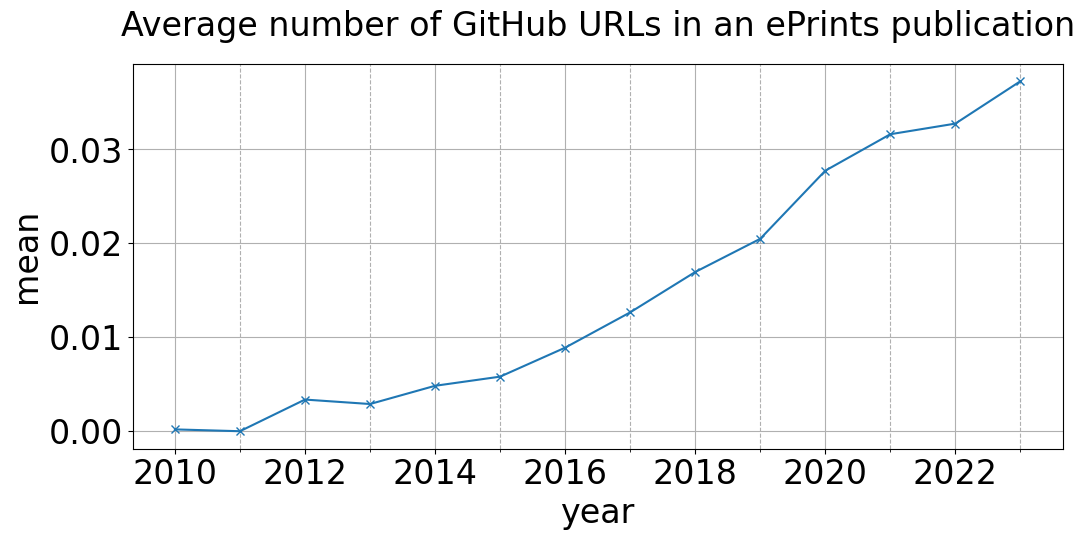

In [116]:
fig2, ax3 = plt.subplots()
urls_per_publication = df.groupby(["year", "title", "author_for_reference", "pdf_url"])["github_user_cleaned_url"].count().rename("url_count")
urls_per_publication.groupby("year").mean().plot(
    ax=ax3,
    xlabel="year",
    ylabel="mean",
    marker="x",
    figsize=(12, 5)
)

ax3.xaxis.set_minor_locator(AutoMinorLocator(2))
ax3.grid(which="major")
ax3.grid(which="minor", linestyle="--")

ax3.set_title("Average number of GitHub URLs in an ePrints publication", pad=20)
fig2.savefig("../../data/derived/plots/overall/avg_github_in_eprints.png", transparent=True, bbox_inches="tight")

Number of publications in ePrints that have at least one GitHub URL:

/tmp/ipykernel_29759/1573375001.py:17: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0, 10**6])


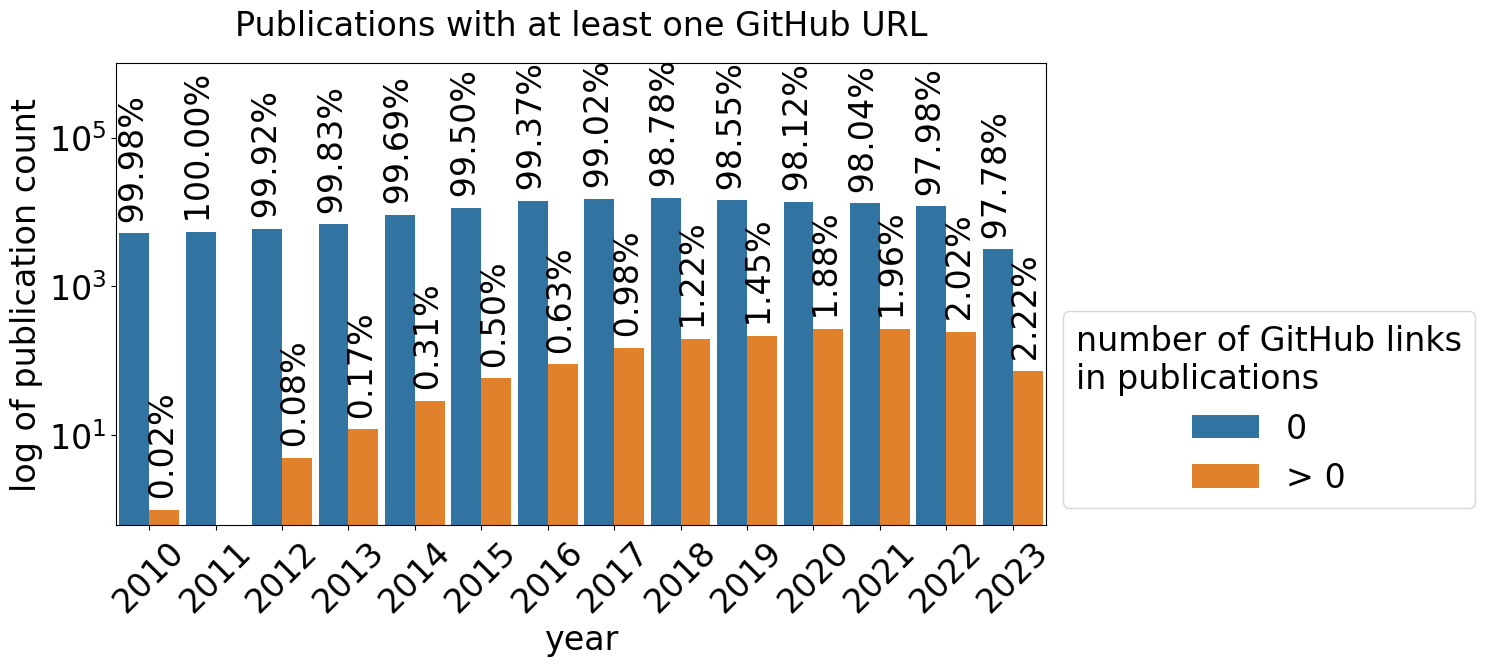

In [87]:
min_one_url = (urls_per_publication > 0).rename("min_one_url").groupby("year").value_counts().rename("pub_count").reset_index()
min_one_url = min_one_url.set_index(["year", "min_one_url"])
new_index = pd.MultiIndex.from_product(min_one_url.index.levels)
min_one_url = min_one_url.reindex(new_index).fillna(0).astype(int)
min_one_url = min_one_url.merge(min_one_url.groupby("year").pub_count.sum().rename("total_pubs"), left_on="year", right_index=True)
percentages = min_one_url["pub_count"] / min_one_url["total_pubs"] * 100

plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=min_one_url.reset_index(),
    x="year",
    y="pub_count",
    hue="min_one_url",
    width=0.9
)
ax.set(yscale="log", ylabel="log of publication count")
ax.set_ylim([0, 10**6])
ax.tick_params(axis='x', labelrotation=45)

ax.bar_label(ax.containers[0], labels=[f" {p:.2f}%" for p in percentages[::2]], rotation=90)
ax.bar_label(ax.containers[1], labels=[f" {p:.2f}%" for p in percentages[1::2]], rotation=90)

leg = ax.get_legend()
leg.set_title("number of GitHub links\nin publications")
leg.set_bbox_to_anchor((1, 0.5))
new_labels = ["0", "> 0"]
for t, l in zip(leg.texts, new_labels):
    t.set_text(l)

plt.title("Publications with at least one GitHub URL", pad=20)
plt.savefig("../../data/derived/plots/overall/min_one_github_in_eprints.png", bbox_inches="tight")

In [ ]:
min_one_url.reset_index()